### Implement PCA using Numpy.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from sklearn.decomposition import PCA
import os
import random

In [ ]:
!unzip /content/yalefaces.zip

Archive:  /content/yalefaces.zip
replace yalefaces/person-4/rightlight? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
base_dir = 'yalefaces'
person_folders = [
    'person-1',
    'person-2',
    'person-3',
    'person-4',
    'person-5',
    'person-6',
    'person-7',
    'person-8',
    'person-9',
    'person-10',
    'person-11',
    'person-12',
    'person-13',
    'person-14',
    'person-15',
]

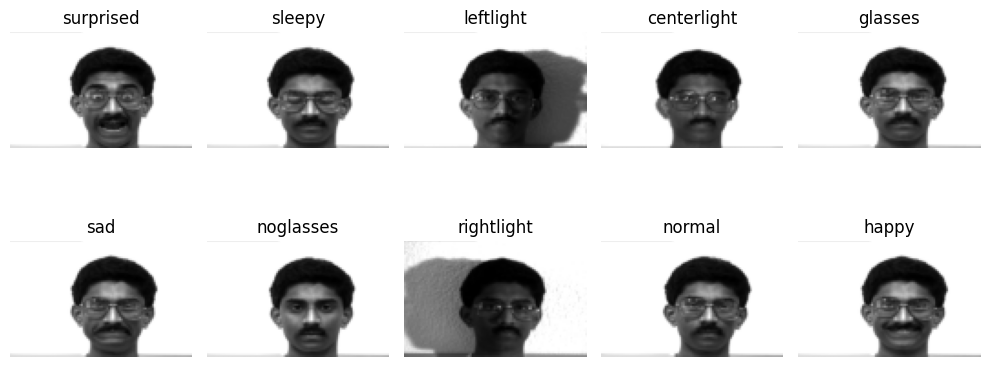

In [ ]:
person_folder = random.choice(person_folders)
plt.figure(figsize=(10,5))
for ith, filename in enumerate(os.listdir(os.path.join(base_dir, person_folder))):
      img_path = os.path.join(base_dir, person_folder, filename)
      img = imread(img_path)
      img = img.squeeze(0)
      img = resize(img, (64, 100), anti_aliasing=True)
      plt.subplot(2, 5, ith + 1)
      plt.imshow(img, cmap='gray')
      plt.axis('off')
      plt.title(filename)

plt.tight_layout()
plt.show()

In [ ]:
data= {}
for  person_folder in person_folders:
  for filename in os.listdir(os.path.join(base_dir, person_folder)):
    img_path = os.path.join(base_dir, person_folder, filename)
    img = imread(img_path)
    img = resize(img, (1, 64, 80), anti_aliasing=True)
    if person_folder not in data:
      data[person_folder]  = [img]
    else:
      data[person_folder].append(img)

for person in data:
  data[person] = np.concat(data[person], axis=0).reshape(10,-1)

### Standardlizing images

In [ ]:
def standardlizing (images: np.ndarray) -> np.ndarray:
  images = (images - images.mean()) / images.std()
  images = images.astype(np.float32)

  return images

### Principle Components Analysis

In [ ]:
from sklearn.preprocessing import StandardScaler

class PrincipleComponentAnalysis:
    def __init__(self, n_components: int = 1):
        self.n_components = n_components
        self.mean = None
        self.scaler = StandardScaler(with_std=False)  # Chỉ chuẩn hóa mean (zero-center)

    def fit(self, X: np.ndarray):
        # Chuẩn hóa dữ liệu (zero-center)
        X_normalized = self.scaler.fit_transform(X)
        self.mean = self.scaler.mean_

        # Tính ma trận hiệp phương sai (sử dụng công thức đúng cho PCA)
        cov = np.cov(X_normalized, rowvar=False)  # Giả sử mỗi hàng là một sample, mỗi cột là một feature

        # Tính eigenvalues và eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Đảm bảo thành phần lớn nhất là dương (tính nhất quán)
        max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
        signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[1])])
        eigenvectors = eigenvectors * signs[np.newaxis, :]

        # Sắp xếp giảm dần
        sorted_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_idx]
        eigenvectors = eigenvectors[:, sorted_idx]

        # Lưu các thành phần chính
        self.components_ = eigenvectors[:, :self.n_components].T
        self.explained_variance_ = eigenvalues[:self.n_components]

    def transform(self, X: np.ndarray) -> np.ndarray:
        # Chuẩn hóa và chiếu dữ liệu
        X_normalized = self.scaler.transform(X)
        return X_normalized @ self.components_.T

    def inverse_transform(self, X_transformed: np.ndarray) -> np.ndarray:
        # Tái tạo dữ liệu gốc (dùng để visualize eigenfaces)
        return (X_transformed @ self.components_) + self.mean

### Finding the Principle Components

In [ ]:
PCA = PrincipleComponentAnalysis(n_components=20)

In [ ]:
images = []
for person in data:
  images.append(data[person])

images = np.concat(images, axis = 0)
images = standardlizing(images)
images.shape

(150, 5120)

In [ ]:
PCA.fit(images)

In [ ]:
PCA.components_.shape

(20, 5120)

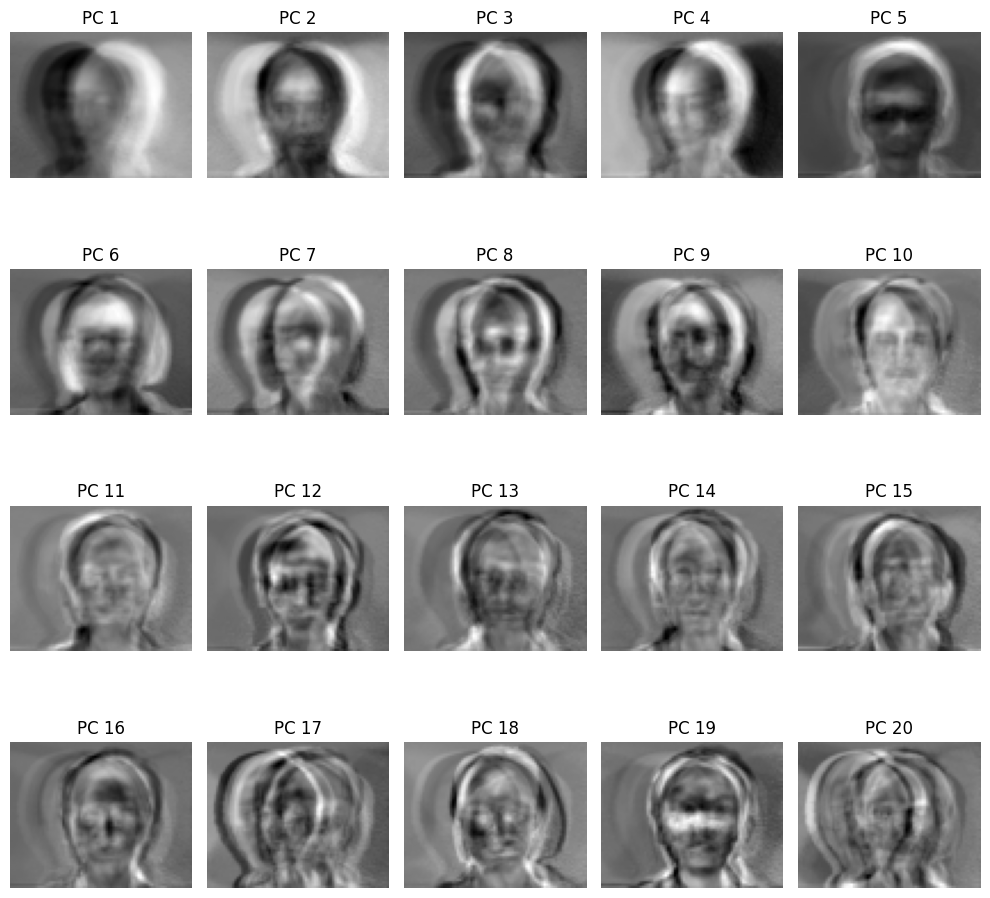

In [ ]:
eigenfaces = PCA.components_
eigenfaces = eigenfaces.reshape(20, 64, 80)
# Hiển thị eigenfaces
plt.figure(figsize=(10, 10))
for ith, eigenface in enumerate(eigenfaces):
    plt.subplot(4, 5, ith + 1)

    # Chuẩn hóa lại giá trị pixel
    eigenface_normalized = (eigenface - eigenface.min()) / (eigenface.max() - eigenface.min())

    plt.imshow(eigenface_normalized, cmap='gray')
    plt.axis('off')
    plt.title(f"PC {ith+1}")

plt.tight_layout()
plt.show()

#### Finding the Mean Face

In [ ]:
mean_faces = {
    person: np.mean(images, axis=0) for person, images in data.items()
}

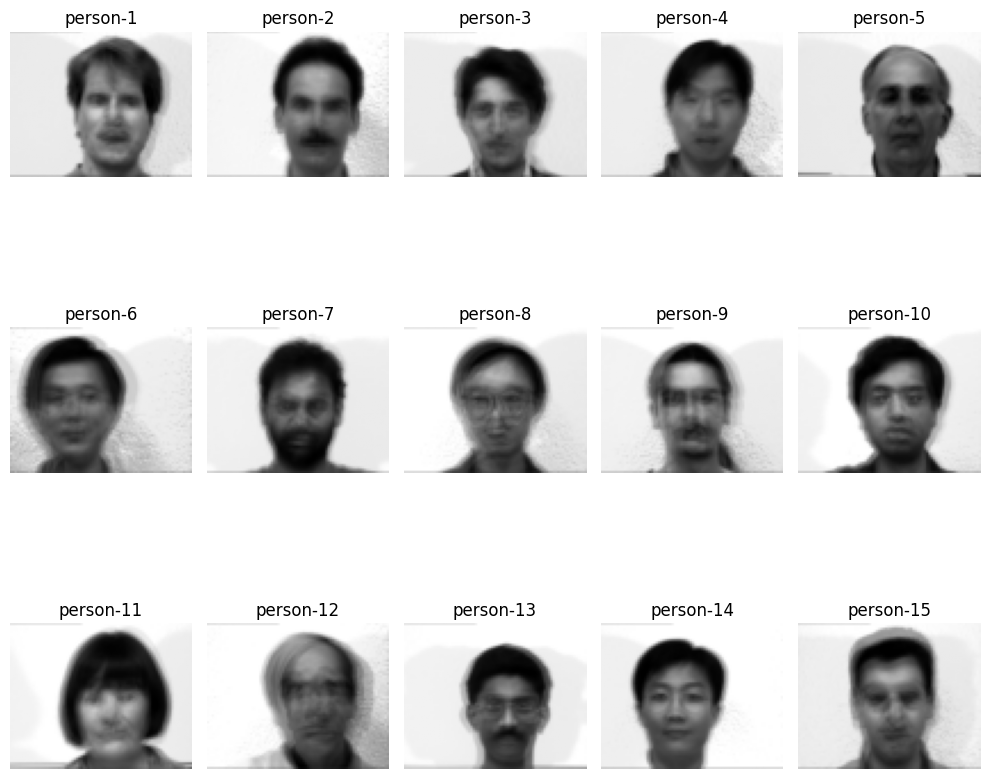

In [ ]:
plt.figure(figsize=(10,10))
for ith, person in enumerate(mean_faces):
    mean_face = mean_faces[person]
    mean_face = mean_face.reshape(64, 80)  # Điều chỉnh giá trị

    # Chuẩn hóa để hiển thị hình ảnh
    mean_face_normalized = (mean_face - mean_face.min()) / (mean_face.max() - mean_face.min())

    plt.subplot(3, 5, ith + 1)
    plt.imshow(mean_face_normalized, cmap='gray')
    plt.axis('off')
    plt.title(person)

plt.tight_layout()
plt.show()

### Project the Mean face into the Principle Space

In [ ]:
projected_mean_faces = {}
for person in mean_faces:
    # First standardize using the same scaler from PCA
    mean_face_normalized = PCA.scaler.transform(mean_faces[person].reshape(1, -1))
    projected_mean_faces[person] = PCA.transform(mean_face_normalized)

### Loading the Test Data

In [ ]:
labels = []
test_images = []
test_dir = '/content/yalefaces/test'

for filename in os.listdir(test_dir):
    if filename.startswith('.'):  # Skip hidden files
        continue

    person_name = filename.split(".")[0]
    labels.append(person_name)

    image = imread(os.path.join(test_dir, filename))
    image = resize(image, (1, 64, 80), anti_aliasing=True)  # Fixed shape parameter
    image = image.flatten()  # Flatten to 1D vector
    test_images.append(image)

In [ ]:
test_images = np.stack(test_images, axis=0)  # Better than concatenate for this case
print("Test images shape:", test_images.shape)  # Should be (n_samples, 64*80)

Test images shape: (15, 5120)


In [ ]:
test_images_normalized = PCA.scaler.transform(test_images)
projected_test = PCA.transform(test_images_normalized)

In [ ]:
# Convert projected_test to 1-D vectors
projected_test = projected_test.reshape(len(projected_test), -1)  # Shape: (n_samples, n_components)

In [ ]:
from scipy.spatial import distance
predicted_labels = []
for i in range(len(projected_test)):
    test_vec = projected_test[i].flatten()

    dists = {}
    for person in projected_mean_faces:
        # Ensure both vectors are comparable
        if not isinstance(projected_mean_faces[person], np.ndarray):
            raise ValueError(f"Mean face for {person} is not a numpy array")

        mean_vec = projected_mean_faces[person].flatten()

        # Verify shapes match
        if test_vec.shape != mean_vec.shape:
            raise ValueError(f"Shape mismatch: test {test_vec.shape} vs mean {mean_vec.shape}")

        dist = distance.euclidean(test_vec, mean_vec)
        dists[person] = dist

    # Check if we found any distances
    if not dists:
        raise ValueError("No distances calculated - empty dictionary")

    predicted_person = min(dists.items(), key=lambda x: x[1])[0]
    predicted_labels.append(predicted_person)

In [ ]:
labels

['person-13',
 'person-6',
 'person-5',
 'person-1',
 'person-10',
 'person-2',
 'person-12',
 'person-4',
 'person-9',
 'person-3',
 'person-8',
 'person-7',
 'person-14',
 'person-15',
 'person-11']

In [ ]:
accuracy = np.mean(np.array(predicted_labels) == np.array(labels))
print(f"Recognition Accuracy: {accuracy:.2%}")

Recognition Accuracy: 66.67%
